## Note, only using comments_df for now until we figure out if it is worth it to use the posts_df as well somehow

# 1: Import Packages, define functions


In [67]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod4/Reddit_NLP/Scripts')
import config
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [68]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [70]:
# we can define a function that removes stopwords 
def process_comment(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [71]:
def capital_percentage(comment):
    tokens = nltk.word_tokenize(comment)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [72]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https"]

# 2: Load in the data

In [73]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')

cursor = connection.cursor()
posts_query = "SELECT * FROM Posts"
comments_query = "SELECT * FROM Comments"

posts_df = pd.read_sql(posts_query, connection)
comments_df = pd.read_sql(comments_query, connection)

In [74]:
posts_df.columns = ['id_num', 'post_title', 'post_author', 'post_upvote_ratio', 'post_id', 'post_class']

In [75]:
comments_df.columns = ['id_num', 'body', 'comment_id', 'parent_id', 'post_id', 'author', 'score', 'comment_class']

In [76]:
import re

pattern = '\w+_(\w+)'
p = re.compile(pattern)

In [77]:
comments_df.post_id = comments_df.post_id.apply(lambda x: p.findall(x)[0])

In [78]:
# GET RID OF NEGATIVE AND LOW SCORES (a negative score in a conservative subreddit could be a brigader for example)
comments_df = comments_df[comments_df.score > 5]

In [79]:
df = comments_df[['body', 'comment_class']]

In [80]:
df.comment_class.value_counts()

right    17251
left     15759
Name: comment_class, dtype: int64

# 3: Initial EDA

In [81]:
df['capital_percentage'] = df.body.apply(capital_percentage)

<ipython-input-81-8329d89493b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital_percentage'] = df.body.apply(capital_percentage)


In [82]:
all_caps = df[df.capital_percentage == 1].sort_values(by='capital_percentage', 
                                                      ascending=False).comment_class.value_counts()

In [83]:
comments_w_most_caps = df.sort_values(by='capital_percentage', 
                                      ascending=False).iloc[0:500].comment_class.value_counts()

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

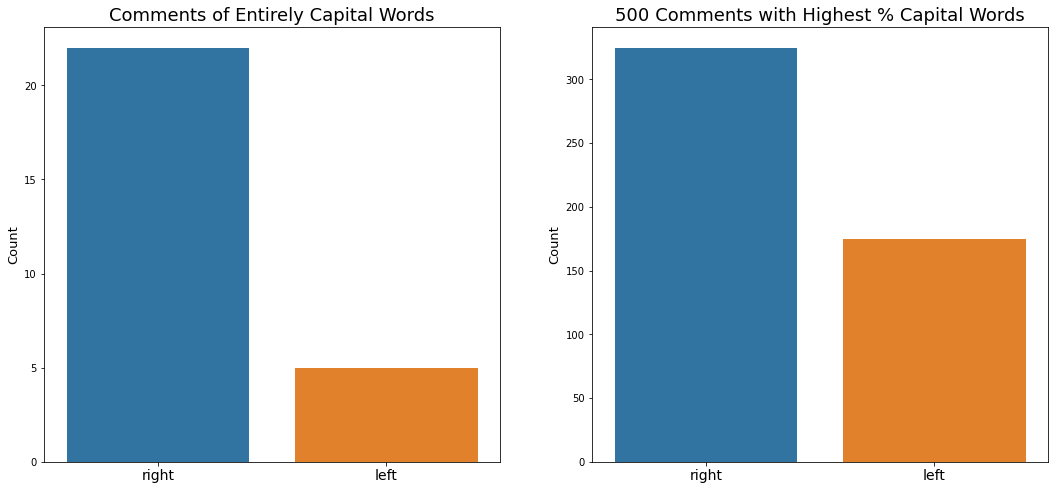

In [84]:
fig = plt.figure(figsize=(18,8))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(all_caps.index, all_caps, ax=ax1)
plt.title("Comments of Entirely Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(comments_w_most_caps.index, comments_w_most_caps, ax=ax2)
plt.title("500 Comments with Highest % Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)


In [85]:
leaning_map = {'right': 1, 'left': 0}
df.comment_class = df.comment_class.map(leaning_map)

In [86]:
df['text_len'] = df['body'].map(lambda x: len(x))

<ipython-input-86-67af6b43cc2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['body'].map(lambda x: len(x))


In [87]:
df = df[df.text_len >= 100]
df.drop('text_len', axis=1, inplace=True)

In [88]:
df.comment_class.value_counts()

1    9106
0    9027
Name: comment_class, dtype: int64

In [89]:
from sklearn.utils import resample
right = df[df.comment_class == 1]
left = df[df.comment_class == 0]

left_upsampled = resample(left,
                          replace=True, # sample with replacement
                          n_samples=len(right), # match number in majority class
                          random_state=42) 
df = pd.concat([right, left_upsampled])
df.comment_class.value_counts()

1    9106
0    9106
Name: comment_class, dtype: int64

# Word Counts and Word Clouds

In [77]:
df_freq_right = df[df['comment_class']==1]
df_freq_left = df[df['comment_class']==0]

data_right = df_freq_right['body']
data_left = df_freq_left['body']

processed_right = list(map(process_comment, data_right))
processed_left = list(map(process_comment, data_left))

In [78]:
# Preprocessing:
# We will use these again later on
# FORMAT:  flat_list = [item for sublist in l for item in sublist]

flat_right = [item for sublist in processed_right for item in sublist]
flat_left = [item for sublist in processed_left for item in sublist]

In [79]:
right_freq = FreqDist(flat_right)
left_freq = FreqDist(flat_left)

In [80]:
right_freq.most_common(20)

[('gun', 2676),
 ('people', 2605),
 ('like', 1841),
 ('would', 1586),
 ('one', 1312),
 ('guns', 1299),
 ('get', 1297),
 ('trump', 1167),
 ('biden', 1166),
 ('right', 1081),
 ('even', 980),
 ('think', 968),
 ('want', 956),
 ('...', 949),
 ('time', 818),
 ('going', 797),
 ('know', 790),
 ('rights', 768),
 ('us', 723),
 ('need', 721)]

In [81]:
left_freq.most_common(20)

[('trump', 4399),
 ('people', 2324),
 ('like', 1645),
 ('would', 1586),
 ('biden', 1577),
 ('vote', 1449),
 ('one', 1147),
 ('get', 1142),
 ('even', 996),
 ('going', 963),
 ('...', 897),
 ('election', 883),
 ('president', 856),
 ('time', 810),
 ('think', 767),
 ('know', 762),
 ('right', 741),
 ('could', 730),
 ('said', 707),
 ('us', 684)]

In [82]:
# create counts of satire and not satire with values and words
right_bar_counts = [x[1] for x in right_freq.most_common(25)]
right_bar_words = [x[0] for x in right_freq.most_common(25)]

left_bar_counts = [x[1] for x in left_freq.most_common(25)]
left_bar_words = [x[0] for x in left_freq.most_common(25)]

In [83]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

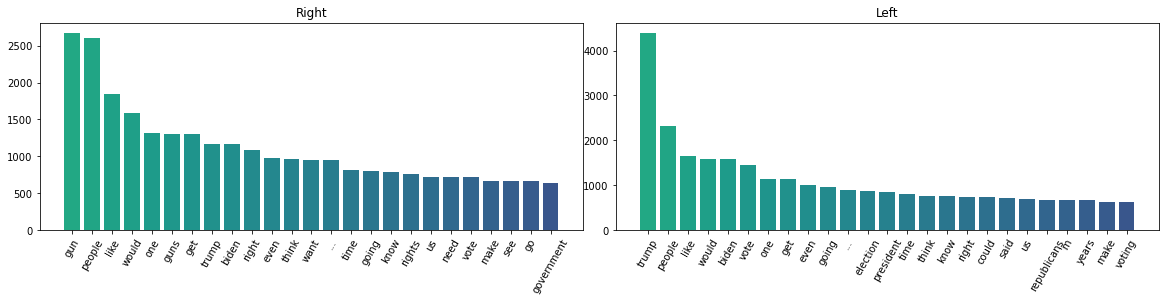

In [84]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(right_bar_words, right_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(left_bar_words, left_bar_counts, color=color )

ax.title.set_text('Right')
ax2.title.set_text('Left')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

In [85]:
# Getting our data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))
#!pip install wordcloud
from wordcloud import WordCloud
right_dictionary = dict(zip(right_bar_words, right_bar_counts))
left_dictionary = dict(zip(left_bar_words, left_bar_counts))

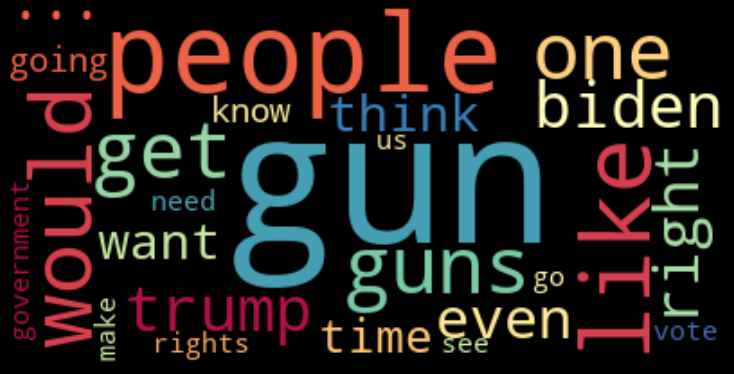

In [86]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(right_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

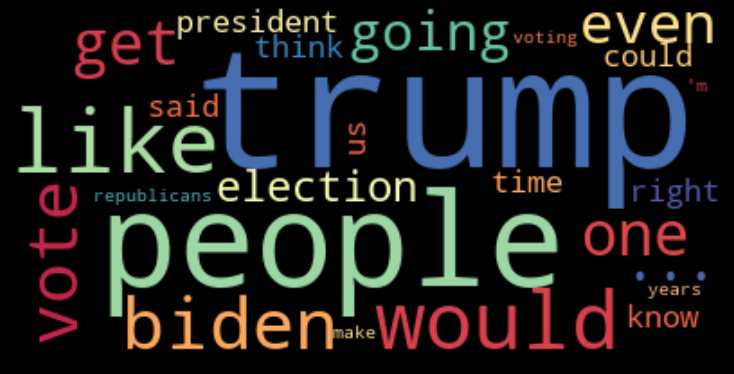

In [87]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(left_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

# Classification

In [91]:
X = df['body']
y = df['comment_class']

In [92]:
#apply above function to data

processed_comments = list(map(process_comment, X))

**Testing Pronouns Class**

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [94]:
X_train

6975     You \*can\* make this stuff up, which is why I...
44245    Anyone actually read why she got fired? Don’t ...
46677    Finally. Obama's absence during this campaign ...
66915    Trump has lost corporate America. He would hav...
23247    Well seeing as how most people in the military...
                               ...                        
13048    Trump, slamming the lid shut on his own traito...
26783    You’re either an *antiracist* or you’re a raci...
54770    So in 2019 where everyone has a high quality c...
66130    FBI did their investigation long ago and decid...
1970     > 'If you're tired of lockdowns ... wearing ma...
Name: body, Length: 11837, dtype: object

In [120]:
from sklearn.base import BaseEstimator, TransformerMixin

In [122]:
class Pronouns(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def count_pronouns(self, doc):
        segment = doc.text.lower().split()
        counter = {"1sg": 0, "1pl": 0}
        for pronoun in FIRST_SINGULAR:
            counter["1sg"] += segment.count(pronoun)
        for pronoun in FIRST_PLURAL:
            counter["1pl"] += segment.count(pronoun)
        return counter
    
    def transform(self, X):
        return pd.Series(X).apply(self.count_pronouns)

In [123]:
pronouns = Pronouns()

In [124]:
pronouns.fit(X_train)
X_train = pronouns.transform(X_train)
X_train

AttributeError: 'str' object has no attribute 'text'

In [95]:
#create list with lemmatized output
lemmatized_output = []

for comment in processed_comments:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in comment])
    lemmatized_output.append(lemmed)

In [96]:
X_lem = lemmatized_output

y_lem = y

In [97]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.35, random_state=1)

In [98]:
type(X_train_lem)

list

In [99]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [41]:
# import spacy 
# from sklearn.base import BaseEstimator, TransformerMixin
# class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, nlp):
#         self.nlp = nlp
#         self.dim = 300

#     def fit(self, X, y):
#         return self

#     def transform(self, X):
#         # Doc.vector defaults to an average of the token vectors.
#         # https://spacy.io/api/doc#vector
#         return [self.nlp(text).vector for text in X]

In [111]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from SpacyVectorTransformer import SpacyVectorTransformer
from Length_Comments import Length_Comments
from Capitalization_Normalizer import Capitalization_Normalizer

In [112]:
embeddings_pipeline = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
        ("classifier", RandomForestClassifier()),
    ]
)
embeddings_pipeline.fit(X_train_lem, y_train_lem)
y_pred = embeddings_pipeline.predict(X_test_lem)
cr = classification_report(y_test_lem, y_pred,output_dict=True)

KeyboardInterrupt: 

In [44]:
report = pd.DataFrame(cr).transpose()

In [45]:
report

,precision,recall,f1-score,support
0,0.794923,0.881404,0.835933,3162.000000
1,0.866690,0.772252,0.816750,3157.000000
accuracy,0.826871,0.826871,0.826871,0.826871
macro avg,0.830807,0.826828,0.826342,6319.000000
weighted avg,0.830778,0.826871,0.826349,6319.000000


In [46]:
tfidf_pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ("classifier", RandomForestClassifier()),
    ]
)
tfidf_pipeline.fit(X_train_lem, y_train_lem)
y_pred = tfidf_pipeline.predict(X_test_lem)
cr = classification_report(y_test_lem, y_pred, output_dict=True)

In [47]:
report = pd.DataFrame(cr).transpose()

In [48]:
report

,precision,recall,f1-score,support
0,0.881587,0.920620,0.900681,3162.000000
1,0.916805,0.876148,0.896016,3157.000000
accuracy,0.898402,0.898402,0.898402,0.898402
macro avg,0.899196,0.898384,0.898348,6319.000000
weighted avg,0.899182,0.898402,0.898350,6319.000000


In [49]:
# individual pipelines minus the estimator step: 
tfidf_pipeline = Pipeline(
    steps=[
        #('lemma', Lemmatize(stopwords)),
        ("tfidf", TfidfVectorizer()),
    ]
)

embeddings_pipeline = Pipeline(
    steps=[
        #('lemma', Lemmatize(stopwords)),
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
    ]
)

capitalization_pipeline = Pipeline(
    steps=[
        ("cap_norm", Capitalization_Normalizer()),
    ]
)

In [50]:
combined_features = FeatureUnion(
    transformer_list=[
        ("tfidf", tfidf_pipeline),
        ("embeddings", embeddings_pipeline),
        #(try adding a pipeline that is just the dense columns)
    ]
)
final_pipeline = Pipeline(
    steps=[
        ("combined_features", combined_features),
        ("classifier", RandomForestClassifier()),
    ]
)

In [51]:
final_pipeline.fit(X_train_lem, y_train_lem)
y_pred = final_pipeline.predict(X_test_lem)
cr = classification_report(y_test_lem, y_pred, output_dict=True)

In [52]:
report = pd.DataFrame(cr).transpose()

In [53]:
report

,precision,recall,f1-score,support
0,0.863401,0.947502,0.903498,3162.000000
1,0.941734,0.849857,0.893440,3157.000000
accuracy,0.898718,0.898718,0.898718,0.898718
macro avg,0.902567,0.898680,0.898469,6319.000000
weighted avg,0.902536,0.898718,0.898473,6319.000000


In [111]:
tfidf = TfidfVectorizer(ngram_range=(1,2))

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

tfidf_data_train_lem

<8126x147124 sparse matrix of type '<class 'numpy.float64'>'
	with 427697 stored elements in Compressed Sparse Row format>

## Random Forest

In [112]:
rfc_lemma = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1,verbose=1)
rfc_lemma.fit(tfidf_data_train_lem, y_train_lem)
rf_test_preds = rfc_lemma.predict(tfidf_data_test_lem)

rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s


Random Forest with Lemmatization Features
Testing Accuracy: 0.8926

F1 Score: 0.889


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


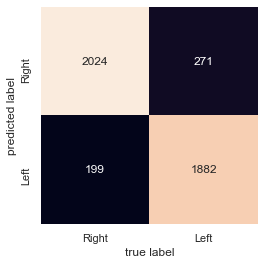

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## MN Naive Bayes

In [114]:
mnb_lemma = MultinomialNB()
mnb_lemma.fit(tfidf_data_train_lem, y_train_lem)
mnb_test_preds = mnb_lemma.predict(tfidf_data_test_lem)

mnb_acc_score_lem = accuracy_score(y_test_lem, mnb_test_preds)
mnb_f1_score_lem = f1_score(y_test_lem, mnb_test_preds)
print('Multinomial Naive Bayes model accuracy')
print("Testing Accuracy: {:.4}".format(mnb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(mnb_f1_score_lem))

Multinomial Naive Bayes model accuracy
Testing Accuracy: 0.8896

F1 Score: 0.8897


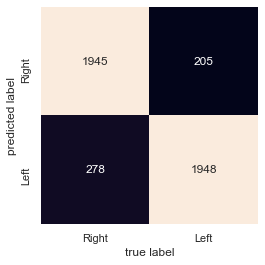

In [115]:
mat = confusion_matrix(y_test_lem, mnb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [116]:
y_test_lem.index

Int64Index([51260, 62757, 50715, 42119, 18732, 84121, 51636, 22929, 28521,
            82515,
            ...
            91810, 99625, 18888, 82216, 28471, 13414, 65454, 60726, 24713,
             2859],
           dtype='int64', length=4376)

In [117]:
test = comments_df.loc[y_test_lem.index]
test['pred'] = rf_test_preds
test['pred'] = test['pred'].apply(lambda x: 'right' if x == 1 else 'left')

In [118]:
guessed_right_wrong = test[(test.comment_class != test.pred) & (test.pred == 'right')]
guessed_right_wrong.reset_index(drop=True, inplace=True)

guessed_left_wrong = test[(test.comment_class != test.pred) & (test.pred == 'left')]
guessed_left_wrong.reset_index(drop=True, inplace=True)


In [119]:
print("GUESSED RIGHT BUT WE WERE WRONG")
print("_______________________________")
for i in range(0,50):
    print(guessed_right_wrong.iloc[i].body)
    print('----------')

GUESSED RIGHT BUT WE WERE WRONG
_______________________________
Voting for Trump means voting to spend your tax dollars paying a rapist's defense attorneys.

If Republicans are spending our tax dollars on defending this disgusting pig's sexual assaults, they can just STFU about the damn debt and deficits.
----------
Not only black. Philly PD is not exactly unified after the past few years. Commissioner Outlaw seems to be getting mixed support
----------
Trump tried to hide behind a wall of regular testing, no expense spared. The tests aren't 100% and since his core team couldn't be seen to take CV19 seriously, someone was going to catch it and slip through the net. 

Nature will find a way...
----------
I don't understand "could face" Federal charges. If I were caught after having helped myself to a bag of mail with the intent to discard ballot envelopes while the carrier left his truck to take a piss, I would be serving prison time.  That's just me...a citizen. A Federal employee entr

In [120]:
print("GUESSED LEFT BUT WE WERE WRONG")
print("______________________________")
for i in range(0,50):
    print(guessed_left_wrong.iloc[i].body)
    print('----------')

GUESSED LEFT BUT WE WERE WRONG
______________________________
Truck in my neighborhood:

Gadsden Flag

COME AND TAKE IT sticker

Back the Blue/Thin Blue Line

???!!!
----------
If Hunter Biden had the last name of Trump and this were to come to light, the MSM would be running with this 24/7. The double standard here is plain as day and absolutely disgusting for people paying attention. It's time we vote and send Biden into retirement for good!
----------
Why don't more Muslims who are lucky to live in France/Europe instead of the shitty countries they came from do more to help the fight against extremism?
----------
It is a very dangerous game the Democrats are playing by blaming foreign governments for their personal failings. When the Russian actually *do* decide to meddle in our elections, no one will believe it because the liberal cried wolf too many times.

Joe Biden is a habitual liar and a generally nasty human being. He knows how to hide it a bit because he has been a chameleon